# ML from scratch: Generalized Linear Models (HARD MODE NOTEBOOK)

### Author: John J. Vastola

In neuroscience, statistical models are essential for making sense of the complex link between neural activity and things in the world (e.g., animal behavior). Among the most useful statistical models are linear ones, because (i) they are simple, and (ii) they are interpretable. [Generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) (GLMs), not to be confused with [general linear models](https://en.wikipedia.org/wiki/General_linear_model), are a slight complexification of the idea of linear models, and are widely applied in neuroscience. In this session, our goal is to cover the basic theory and a simple application to real neural data. 

See the [Github repo](https://github.com/DrugowitschLab/ML-from-scratch-seminar/tree/master/GLMs) for GLM notes, powerpoint slides, and additional information.

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pickle   # for saving/loading data subset
import time as ti  # for timing

## Goal: Fit neural data from MEC using a Poisson GLM

In the spirit of [Hardcastle et al. 2017](https://doi.org/10.1016/j.neuron.2017.03.025), our goal is to fit neural data from mouse medial entorhinal cortex (MEC) using a Poisson GLM. Such a GLM assumes each neuron responds to behavioral variables (e.g., instantaneous position) independently, and with Poisson-like statistics. The generative model for the number of spikes $r$ observed in a small amount of time $\Delta t$ is
$$ 
p(r | \mathbf{x}, \mathbf{w}, w_0) = \mathcal{P}( r; \exp(\mathbf{w}^T \mathbf{x} + w_0) \Delta t ) \ ,
$$
i.e., it is Poisson with mean
$$
\mu = \exp( \mathbf{w}^T \mathbf{x} + w_0  ) \ .
$$

We will assume neurons respond to **three types of variables**, all measured at the current time: (i) **2D position**, (ii) **heading direction**, and (iii) **body speed**. We will use a binned state representation that encodes each behavioral variable in a one-hot fashion, i.e., there are $N_H$ heading direction bins that span $[0, 2 \pi)$, and the corresponding feature is equal to $1$ if the animal's current heading is within that bin, and zero otherwise.

We have three kinds of inputs: $\mathbf{x}_P$ (binned 2D position, size = $N_x N_y$), $\mathbf{x}_H$ (binned heading, size = $N_H$), and $\mathbf{x}_S$ (binned speed, size = $N_S$). The predictor is
$$
w_0 + \mathbf{w}^T \mathbf{x} = w_0 + \mathbf{w}^T_P \mathbf{x}_P + \mathbf{w}^T_H \mathbf{x}_H + \mathbf{w}^T_S \mathbf{x}_S = w_0 + \sum_{i, j} w_{P i j} x_{P i j} + \sum_{i = 1}^{N_H} w_{H i} x_{H i} + \sum_{i = 1}^{N_S} w_{S i} x_{S i} \ .
$$
In total, our model depends on $N_x \cdot N_y + N_H + N_S + 1$ parameters.

**Outcome.** Fitting a GLM will allow us to plot the weights as a function of behavioral variables. This matters since, the way we've set things up, the weights essentially reflect tuning curves. We can see if a given cell responds mostly to position, heading, speed, or exhibits mixed selectivity.

## Step 0. Extract data

We will use a subset of data from [Mallory and Hardcastle et al. 2021](https://www.nature.com/articles/s41467-021-20936-8), which is publicly available and can be found [here](https://figshare.com/authors/Lisa_Giocomo/9864194) (dataset 1). The dataset includes $n = 179$ neurons collected from the MEC of 6 freely moving mice. These mice performed a foraging task in small rectangular arenas. For more details, see the methods section of the paper.

We will consider **4 neurons recorded from a single mouse during a single session**. If you would like to use more/different data, download dataset 1 yourself and modify the extraction procedure used in the other notebook (`mec_data_extraction.ipynb`).

In [67]:
name = 'data/mec_data_small'
with open(name+'.pickle', 'rb') as handle:
    data = pickle.load(handle)

time = data['time']
dt = time[1] - time[0]
x_t, y_t = data['body_position_x'], data['body_position_y']
HD_t = data['azimuthal_head_direction']
speed_t = data['body_speed']
counts = data['counts']

In [13]:
for c in data:
    print(c, data[c].shape)

body_position_x (120043,)
body_position_y (120043,)
body_speed (120043,)
azimuthal_head_direction (120043,)
azimuthal_head_velocity (120043,)
pitch (120043,)
roll (120043,)
time (120043,)
counts (4, 120043)


We will only use a few fields: `body_position_x` (animal $x$ position over time), `body_position_y` (animal $y$ position over time), `azimuthal_head_direction` (animal HD over time), `body_speed` (animal body speed over time), and `counts` (time-binned spike counts for each of 4 neurons over time). You can use the other ones if you want to try complexifying your GLM.

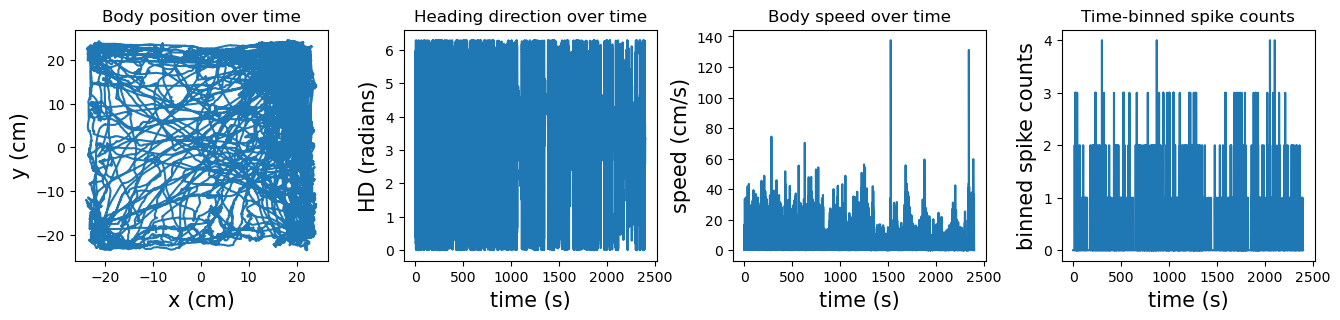

In [10]:
# Plot data

fig, ax = plt.subplots(ncols=4, figsize=(16, 3))

ax[0].plot(data['body_position_x'], data['body_position_y'])
ax[0].set_xlabel('x (cm)', fontsize=15); ax[0].set_ylabel('y (cm)', fontsize=15)
ax[0].set_title('Body position over time')

ax[1].plot(time, data['azimuthal_head_direction'])
ax[1].set_xlabel('time (s)', fontsize=15); ax[1].set_ylabel('HD (radians)', fontsize=15)
ax[1].set_title('Heading direction over time')

ax[2].plot(time, data['body_speed'])
ax[2].set_xlabel('time (s)', fontsize=15); ax[2].set_ylabel('speed (cm/s)', fontsize=15)
ax[2].set_title('Body speed over time')

ax[3].plot(time, data['counts'][0])        # only visualize first neuron
ax[3].set_xlabel('time (s)', fontsize=15); ax[3].set_ylabel('binned spike counts', fontsize=15)
ax[3].set_title('Time-binned spike counts')


plt.subplots_adjust(wspace=0.3)
plt.show()

## Requirements

- 80-20 train-test split (consider each time point as a different sample from the same distribution)
- One-hot encoding of behavior variables
- Fit Poisson GLM model to data from at least one neuron
- fraction deviance explained by model, evaluated on test set, is > 0.85 for at least one neuron